# 方策勾配

せっかく[スライド](../slides/Multi_step_RL.pdf)を書いたので、マルチステップRLの方策勾配を実装します。

In [19]:
import numpy as np
from itertools import product
from functools import partial
from typing import Optional, NamedTuple
import jax.numpy as jnp

def create_rew_P(S: int, A: int, random_transition: float, rew_state_id: int):
    """ Garnet MDP (報酬関数, 遷移確率) を作成します

    Args:
        S (int): 状態空間のサイズ
        A (int): 行動空間のサイズ　
        random_transition (float): ランダムな遷移確率
        rew_state (int): 報酬1の状態のid

    Returns:
        rew (float): 報酬関数
        P (float): 遷移確率
    """
    assert A == 3  # 今回はA==3で固定です

    # 報酬関数はスパースにしておきます
    rew = np.zeros((S, A))
    rew[rew_state_id, np.random.randint(A)] = 1.0

    # 遷移確率を作ります
    # a=0でsに停滞
    # a=1でs-1に移動
    # a=2でs+1に移動
    # 確率 e でランダムにどれかに移動
    P = np.zeros((S, A, S))
    for s, a in product(range(S), range(A)):
        P[s, a, s] = random_transition / 2
        P[s, a, (s-1) % S] = random_transition / 2
        P[s, a, (s+1) % S] = random_transition / 2
        if a == 0: 
            ns = s % S
        elif a == 1: 
            ns = (s - 1) % S
        elif a == 2: 
            ns = (s + 1) % S
        P[s, a, ns] = 1.0 - random_transition
    P = P / P.sum(axis=-1, keepdims=True)
    P = P.reshape(S, A, S)
    np.testing.assert_almost_equal(P.sum(axis=-1), 1)
    return jnp.array(rew), jnp.array(P)


class MDP(NamedTuple):
    S_array: np.array  # 状態空間
    A_array: np.array  # 行動空間
    gamma: float  # 割引率
    horizon: int  # ホライゾン
    rew: float  # 報酬関数
    P: float  # 遷移確率
    optimal_Q: Optional[np.ndarray] = None  # 最適Q値
    optimal_Q_idx: Optional[np.ndarray] = None  # 後でplot用に使います

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_array)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_array)


S = 20
rew_state_id = 4
A = 3
b = 1
S_array = np.arange(S)
A_array = np.arange(A)
gamma = 0.99
horizon = int(1 / (1 - gamma))

# Garnet MDPを作ります
random_transition = 0.3
t_rew, t_P = create_rew_P(S, A, random_transition, rew_state_id)
mdp = MDP(S_array, A_array, gamma, horizon, t_rew, t_P)

GarnetMDPでValue Iterationを動かしてみましょう。

実験の前に、いくつか便利な関数を導入します。

1. ``compute_greedy_policy``: Q関数 ($S \times A \to \mathcal{R}$) の貪欲方策を返します
2. ``compute_optimal_Q``: MDPの最適Q関数 $q_* : S \times A \to \mathcal{R}$ を返します。
3. ``compute_policy_Q``: 方策 $\pi$ のQ関数 $q_\pi : S \times A \to \mathcal{R}$ を返します。
4. ``compute_discounted_visitation``: hステップの割引訪問頻度$d_h^\pi: S \to \mathcal{R}$を返します。

In [20]:
from functools import partial
import jax
import chex


# >>>> 1 >>>>
@jax.jit
def compute_greedy_policy(Q: np.ndarray):
    greedy_policy = jnp.zeros_like(Q)
    S, A = Q.shape
    greedy_policy = greedy_policy.at[jnp.arange(S), Q.argmax(axis=1)].set(1)
    assert greedy_policy.shape == (S, A)
    return greedy_policy
# <<<< 1 <<<<


# >>>> 2 >>>>
@partial(jax.jit, static_argnames=("S", "A"))
def _compute_optimal_Q(mdp: MDP, S: int, A: int):

    def backup(optimal_Q):
        greedy_policy = compute_greedy_policy(optimal_Q)
        max_Q = (greedy_policy * optimal_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    optimal_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon, body_fn, optimal_Q)

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp, mdp.S, mdp.A)
# <<<< 2 <<<<


# >>>> 3 >>>>
@jax.jit
def compute_policy_Q(mdp: MDP, policy: np.ndarray):
    S, A = policy.shape

    def backup(policy_Q):
        max_Q = (policy * policy_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    policy_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon, body_fn, policy_Q)
# <<<< 3 <<<<


# >>>> 4 >>>>
@partial(jax.jit, static_argnames=("h"))
def compute_discounted_visitation(mdp: MDP, policy: np.ndarray, h: int):
    S, A = policy.shape
    P = mdp.P.reshape(S * A, S)

    def backup(i, visits):
        visit = visits[i]
        visit_policy = (visit.reshape(S, 1) * policy).reshape(S * A)
        next_visit = mdp.gamma * visit_policy @ P
        visits = visits.at[i+1].set(next_visit)
        chex.assert_shape(visit, (S,))
        return visits
    
    visits = jnp.zeros((h, S))
    visits = visits.at[0, int((S - 1) / 2)].set(1.0)  # 初期状態は一つだけにします
    visits = jax.lax.fori_loop(0, h-1, backup, visits)
    return visits.sum(axis=0)
# <<<< 4 <<<<


mdp = mdp._replace(optimal_Q=compute_optimal_Q(mdp))
optimal_Q = compute_optimal_Q(mdp)
policy = compute_greedy_policy(optimal_Q)
assert compute_discounted_visitation(mdp, policy, 2).sum() == 1 + mdp.gamma

方策はsoftmax parameterizationとします。つまり、

$$\pi_\theta (a|s) = \frac{\exp(\theta(s, a))}{\sum_{a'} \exp(\theta(s, a'))}$$

です。このとき、

$$
\log(\pi_\theta (a|s))=\theta(s, a) - \log\left({\sum_{a'} \exp(\theta(s, a'))}\right)
$$
です。ここで、$A$次元ベクトル $\theta$ について、

$$
\nabla_\theta \log\left(\sum_{a} \exp\left(\theta(a)\right)\right)=\frac{\exp(\theta)}{\sum_{a} \exp(\theta(a))}
$$
なので、
$$
\nabla_\theta \log(\pi_\theta)={\bf 1} - \pi_\theta
$$
です。よって、

$$
\nabla_\theta J_h (\theta) = \sum_{s, a} d^{\pi_\theta}_h (s) \nabla_\theta \log \pi_\theta (a|s) Q_{\pi_\theta}(s, a)
= \sum_{s, a} d^{\pi_\theta}_h (s) ({\bf 1}_{s, a} - (\pi_\theta)_{s})Q_{\pi_\theta}(s, a)
$$
になります (${\bf 1}_{s, a}$ は$(s, a)$の要素だけ1でほか全部0のベクトル、$(\pi_\theta)_{s}$は$(s)$の要素だけ$\pi_\theta(s)$でほか全部0のベクトルです。つまり、Qがでかくなる方に方策を寄せるわけですね。

In [28]:
import jax
from itertools import product
from functools import partial

key = jax.random.PRNGKey(0)
theta = jax.random.uniform(key, (S, A))

def log_pi(theta, s, a):
    return jnp.log(jax.nn.softmax(theta)[s, a])


@partial(jax.vmap, in_axes=(None, 0))
def compute_log_pol_grad(theta, sa):
    # 解析的な勾配
    s, a = sa
    grad = jnp.zeros((S, A))
    grad = grad.at[s, a].set(1)
    pi = jax.nn.softmax(theta)
    grad = grad.at[s].add(-pi[s])
    return grad


@partial(jax.vmap, in_axes=(None, 0))
def compute_jax_log_pol_grad(theta, sa):
    # jaxで計算した勾配
    s, a = sa
    jax_grad = jax.grad(log_pi)(theta, s, a)
    chex.assert_shape(jax_grad, (S, A))
    return jax_grad


S_array = mdp.S_array
S_array = jnp.tile(S_array, mdp.A).reshape(-1, 1)

A_array = mdp.A_array
A_array = jnp.repeat(A_array, mdp.S).reshape(-1, 1)

SA = jnp.hstack([S_array, A_array])

grad = compute_log_pol_grad(theta, SA)
jax_grad = compute_jax_log_pol_grad(theta, SA)

np.testing.assert_allclose(grad, jax_grad, rtol=1e-5)


# 勾配の計算器

@partial(jax.jit, static_argnames=("h"))
def compute_policy_gradient(mdp, theta, Q, h):
    S, A = Q.shape

    S_array = jnp.repeat(mdp.S_array, A).reshape(S*A, 1)
    A_array = jnp.tile(mdp.A_array, S).reshape(S*A, 1)
    SA = jnp.hstack([S_array, A_array])

    log_pi_grad = compute_log_pol_grad(theta, SA).reshape(S*A, S*A)  # (S*A, S, A)
    Q = Q.reshape(S*A, 1)
    pi = jax.nn.softmax(theta).reshape(S*A, 1)
    x = (pi * log_pi_grad * Q).reshape(S, A, S*A).sum(axis=1)  # (S, S*A)

    d_pi = compute_discounted_visitation(mdp, policy, h).reshape(S, 1)
    grad = (d_pi * x).sum(axis=0).reshape(S, A)
    return grad


policy = jax.nn.softmax(theta)
Q = compute_policy_Q(mdp, policy)
h = 2
grad = compute_policy_gradient(mdp, theta, Q, h)
chex.assert_shape(grad, (S, A))

試しにQ関数が完璧な状況で実際に方策勾配法が収束するか見てみましょう。hが大きいほうが収束が早いですね。

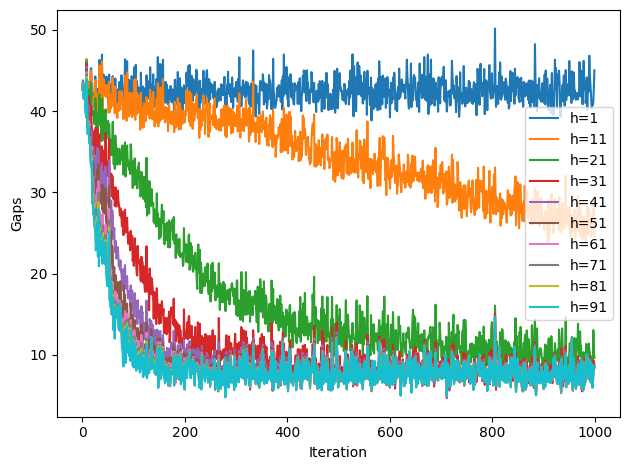

In [37]:
import matplotlib.pyplot as plt


def policy_gradient(mdp: MDP, h: int, lr: float, key):
    theta = jax.random.uniform(key, (S, A))
    
    gaps = []
    for _ in range(1000):
        policy = jax.nn.softmax(theta)
        key, _ = jax.random.split(key)
        error = jax.random.normal(key, (S, A)) * 3
        Q = compute_policy_Q(mdp, policy) + error
        grad = compute_policy_gradient(mdp, theta, Q, h)
        theta = theta + lr * grad
        gaps.append(jnp.abs(mdp.optimal_Q - Q).max())
    return Q, gaps


key = jax.random.PRNGKey(0)

for h in range(1, 100, 10):
    Q, gaps = policy_gradient(mdp, h, 0.1, key)
    plt.plot(gaps, label=f"h={h}")
plt.xlabel("Iteration")
plt.ylabel("Gaps")
plt.tight_layout()
plt.legend()